In [2]:
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.linear_model
import sklearn.neural_network
import matplotlib.pyplot as plt

/Users/steve/.local/share/virtualenvs/teaching-kL1iKbCK/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

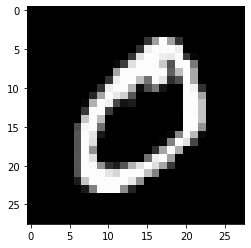

In [6]:
plt.imshow(x_train[1], cmap='gray')

In [7]:
x_train.max(), x_train.min()

(255, 0)

In [8]:
x_train = x_train / 255.
x_test = x_test / 255.

In [9]:
x_trainf = x_train.reshape(-1, 28*28)
x_testf = x_test.reshape(-1, 28*28)

## Baseline: linear classifier

In [10]:
lr = sklearn.linear_model.LogisticRegression(solver='saga', tol=0.1)
lr = lr.fit(x_trainf, y_train)

In [11]:
print(f'train: {lr.score(x_trainf, y_train)}')
print(f'test: {lr.score(x_testf, y_test)}')

train: 0.9307
test: 0.9244


In [12]:
y_pred_train = lr.predict(x_trainf)
y_pred_test = lr.predict(x_testf)

In [13]:
np.sum(y_pred_test == y_test) / y_test.shape[0]

0.9244

In [14]:
np.sum(y_pred_train == y_train) / y_train.shape[0]

0.9307

## MLP in sklearn

In [15]:
net_skl = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(128, ), activation='relu', solver='sgd',
    tol=1e-2, max_iter=100,
    early_stopping=True
)
net_skl = net_skl.fit(x_trainf, y_train)

In [16]:
print(f'train: {net_skl.score(x_trainf, y_train)}')
print(f'test: {net_skl.score(x_testf, y_test)}')

train: 0.9131833333333333
test: 0.9167


In [17]:
net_skl = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(128, 128, ), activation='relu', solver='sgd',
    tol=1e-2, max_iter=100,
    early_stopping=True
)
net_skl = net_skl.fit(x_trainf, y_train)

In [18]:
print(f'train: {net_skl.score(x_trainf, y_train)}')
print(f'test: {net_skl.score(x_testf, y_test)}')

train: 0.9289333333333334
test: 0.931


## MLP in keras

In [19]:
y_trainv = tf.keras.utils.to_categorical(y_train)
y_testv = tf.keras.utils.to_categorical(y_test)

In [20]:
net_ker = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(28 * 28,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
net_ker.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['mse', 'accuracy']
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=20)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [21]:
history = net_ker.fit(
    x_trainf, y_trainv,
    batch_size=128,
    epochs=20,
    validation_data=(x_testf, y_testv),
    callbacks=[early_stopping_callback, tensorboard_callback],
)

Epoch 1/20


2022-05-19 15:36:06.555239: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 6s 12ms/step - loss: 0.2511 - mse: 0.0114 - accuracy: 0.9241 - val_loss: 0.1137 - val_mse: 0.0053 - val_accuracy: 0.9643
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0958 - mse: 0.0045 - accuracy: 0.9706 - val_loss: 0.0793 - val_mse: 0.0037 - val_accuracy: 0.9763
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0648 - mse: 0.0031 - accuracy: 0.9803 - val_loss: 0.0789 - val_mse: 0.0037 - val_accuracy: 0.9755
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0475 - mse: 0.0023 - accuracy: 0.9858 - val_loss: 0.0686 - val_mse: 0.0032 - val_accuracy: 0.9795
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0358 - mse: 0.0017 - accuracy: 0.9889 - val_loss: 0.0856 - val_mse: 0.0037 - val_accuracy: 0.9770
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0274 - mse: 0.0013 - accuracy: 0.9913 - val_loss: 0.0672 - v

## CNN in Keras

In [75]:
x_trainc = x_train.unsqueeze(3).numpy()
x_testc = x_test.unsqueeze(3).numpy()
x_trainc.shape, x_testc.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [78]:
cnn_ker = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
cnn_ker.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['mse', 'accuracy']
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=20)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [79]:
print(cnn_ker.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_10 (Flatten)        (None, 9216)              0         
                                                                 
 dense_23 (Dense)            (None, 128)               1179776   
                                                     

In [80]:
history = cnn_ker.fit(
    x_trainc, y_trainv,
    batch_size=128,
    epochs=20,
    callbacks=[early_stopping_callback, tensorboard_callback],
)

Epoch 1/20
469/469 [==============================] - 6s 13ms/step - loss: 0.1995 - mse: 0.0089 - accuracy: 0.9398
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0686 - mse: 0.0031 - accuracy: 0.9796
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0502 - mse: 0.0023 - accuracy: 0.9851
Epoch 4/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0429 - mse: 0.0020 - accuracy: 0.9867
Epoch 5/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0370 - mse: 0.0017 - accuracy: 0.9890
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0323 - mse: 0.0015 - accuracy: 0.9904
Epoch 7/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0285 - mse: 0.0014 - accuracy: 0.9913
Epoch 8/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0271 - mse: 0.0013 - accuracy: 0.9915
Epoch 9/20
469/469 [==============================] - 6s 12ms/step - loss: 0.025

## MLP in PyTorch

In [22]:
import torch

In [23]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [24]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)  # flatten input to 1D
        Y = self.Y[index].long()
        return X,Y

In [25]:
num_workers = 8 if torch.cuda.is_available() else 0 

if torch.cuda.is_available():
    loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True)
else:
    loader_args = dict(shuffle=True, batch_size=64)

train_dataset = MyDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, **loader_args)

test_dataset = MyDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, **loader_args)

In [26]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, size_list):
        super(SimpleMLP, self).__init__()
        self.size_list = size_list
        layers = []
        for i in range(len(size_list) - 2):
            layers.append(torch.nn.Linear(size_list[i], size_list[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size_list[-2], size_list[-1]))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Alternatively, you can use a similar syntax to Keras, using the `torch.nn.Sequential` class directly (less flexible, but more concise code):

In [27]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(32,128),
#     torch.nn.Sigmoid(),
#     torch.nn.Linear(128,10)
# )

In [28]:
model = SimpleMLP([784, 256, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [30]:
import time 

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [31]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [32]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  0.3021611037022714 Time:  1.6115787029266357 s
Testing Loss:  0.1535857659141729
Testing Accuracy:  95.54 %
Training Loss:  0.12569630306873367 Time:  1.5813071727752686 s
Testing Loss:  0.1051646373976188
Testing Accuracy:  96.73 %
Training Loss:  0.08410140344583149 Time:  1.5775258541107178 s
Testing Loss:  0.08762456234069957
Testing Accuracy:  97.37 %
Training Loss:  0.060297223563089586 Time:  1.5693929195404053 s
Testing Loss:  0.07291408957154223
Testing Accuracy:  97.71 %
Training Loss:  0.04541670256453171 Time:  1.5989398956298828 s
Testing Loss:  0.07077806619304428
Testing Accuracy:  97.77 %
Training Loss:  0.03444646570413534 Time:  1.570796012878418 s
Testing Loss:  0.07768032452755957
Testing Accuracy:  97.6 %
Training Loss:  0.02663891622300214 Time:  1.5562067031860352 s
Testing Loss:  0.07344077149803518
Testing Accuracy:  97.75 %
Training Loss:  0.021523408940682973 Time:  1.5929877758026123 s
Testing Loss:  0.06749572532005299
Testing Accuracy:  97.

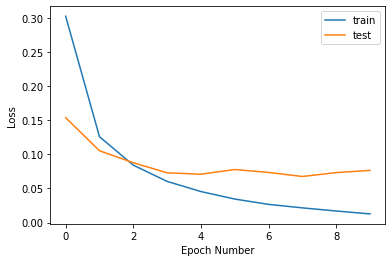

In [33]:
# plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss, label='train')
plt.plot(Test_loss, label='test')
plt.legend();

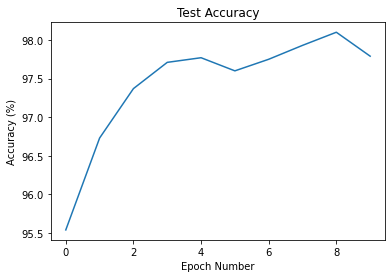

In [35]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc);